## Whale Sound Mining


Objectives:

* learn how apply linear \& nonlinear dimensionality reduction
* learn how to explore multidimensional data



### Data Loading and Exploration
---

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
#import seaborn

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# importing scientific python packages
import numpy as np
import pandas as pd

In [5]:
# a function for plotting spectrograms
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = pl.imshow(Z, extent=extent,cmap = 'plasma')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

In [6]:
# loading the data
X = np.load('X.npy')
y = np.load('y.npy')

### Machine Learning Methods Overview
---

Choosing a Machine Learning Algorithm as of 2013.

[//]:![text](https://gist.githubusercontent.com/amueller/4642976/raw/e48eff2df7790583f1f3212095d24639738a1b4a/drop_shadows.svg?sanitize=true)

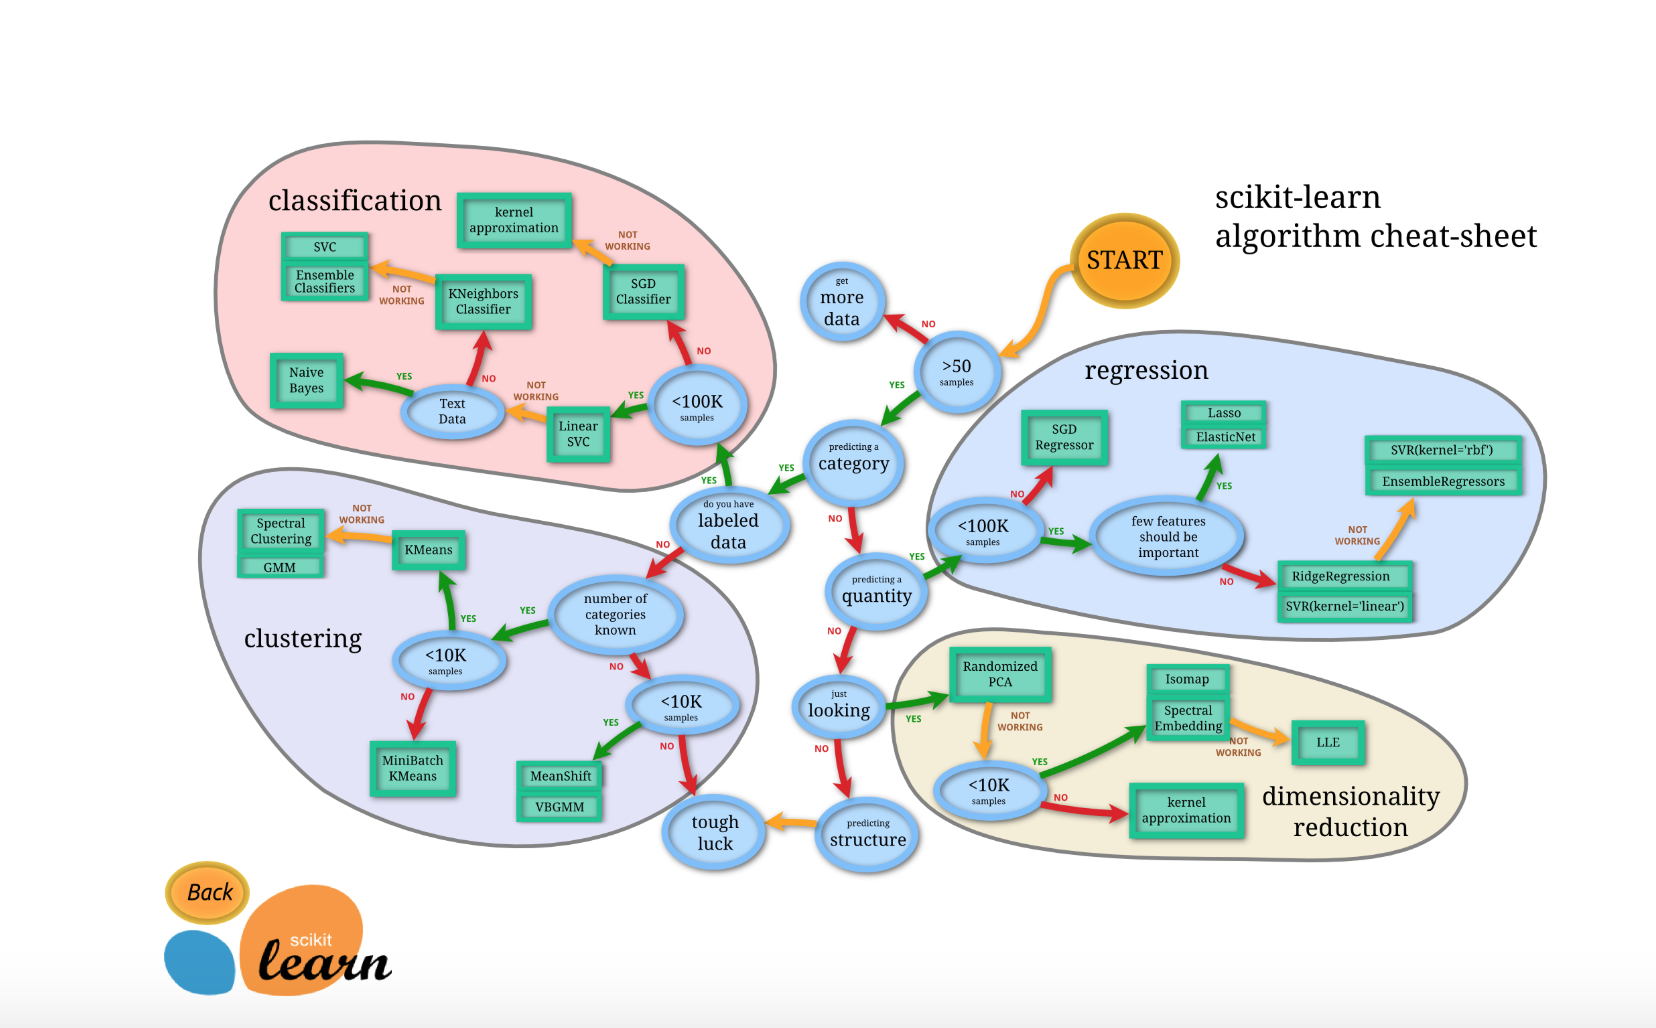

In [7]:
from  IPython.display import Image
Image("img/MLmap.png" )

Source: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

### Dimensionality Reduction
---

We can now represent each signal with its spectrogram, which can be treated as a high dimensional vector. However, we can try to look for common patterns in those spectrograms and attempt to represent them with fewer dimensions. This can be accomplished by dimenionsality techniques such as Principal Component Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)) and Independent Component Analysis ([ICA](https://en.wikipedia.org/wiki/Independent_component_analysis)). These techniques are easy to apply with the Python's `scikit-learn` library.

#### PCA

Principal component analysis projects the data onto a new coordinate system, built off the directions of most variation.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30,copy=True)
X_transformed = pca.fit_transform(np.log(X))

The dimensions of the transformed array are (often called coefficients):

In [9]:
X_transformed.shape

(10000, 30)

The dimensions of the principal components are:

In [10]:
pca.components_.shape

(30, 3540)

Why did I pick 30 components? To decide on the number of components one usually uses the 'elbow rule' on the plot of the singular values.

Text(0.5, 1.0, 'Singular values')

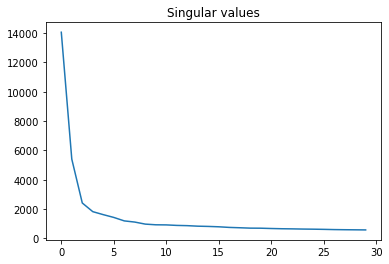

In [11]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

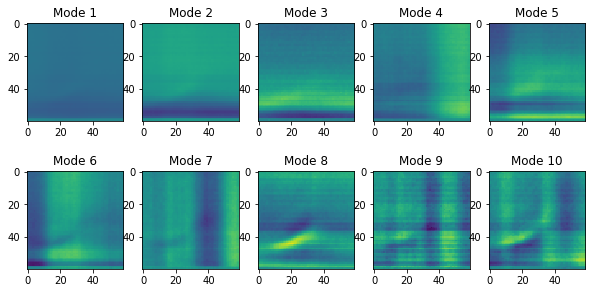

In [12]:
# plot first ten components
plt.figure(figsize = (10,5))
m = 60
spec_dim = [60,59]
u = pca.components_[:,:].reshape(30,-1,m-1)
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((np.squeeze(np.flipud(u[i,:,:])-u.min()))/(u.max() - u.min()), vmin = 0, vmax = 1,cmap = 'viridis')
    #PlotSpecgram(u[i,:,:],freqs[:m],bins)
    plt.title('Mode '+str(i+1))

In [13]:
# Exercise: try Nonnegative Matrix Factorization(NMF), Independent Component Analysis(ICA)
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
# ???

**Visualizing the Transformed Data**

Let's project the data on the first two components.

Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

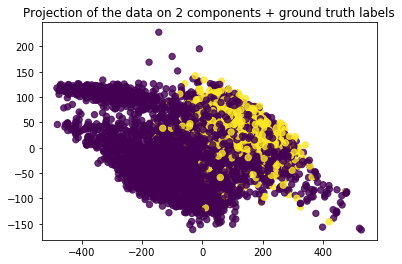

In [14]:
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=40, c = y,  marker='o', alpha=.8)
#plt.xlim(-100000,100000)
#plt.ylim(-100000,100000)
plt.title("Projection of the data on 2 components + ground truth labels")

Two dimensions do not seem sufficient to separate the dataset. Let's see whether this projection is interpretable. We will superimpose the spectrograms on the plot.

In [15]:
# The code below visualizes the data projected in 2D together with the original spectrograms

from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 color=plt.cm.viridis(y[i] / 0.01),
                 #color=colors[i],
                 #color=int(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.log(X[i,:].reshape(spec_dim)),zoom = 0.3, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

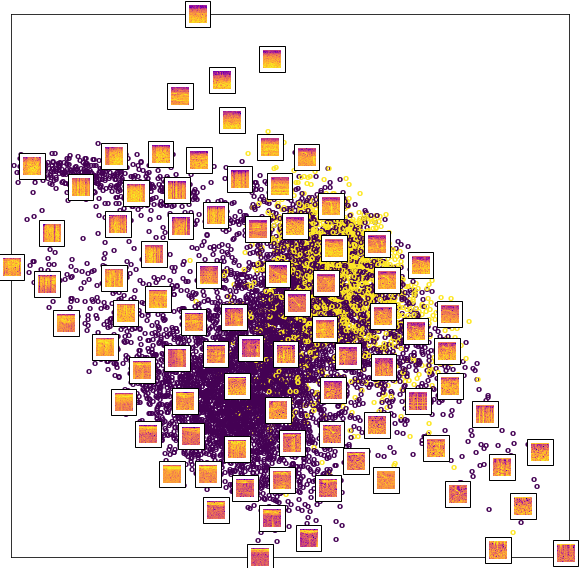

In [16]:
plot_embedding(np.array(X), X_transformed[:,:2])

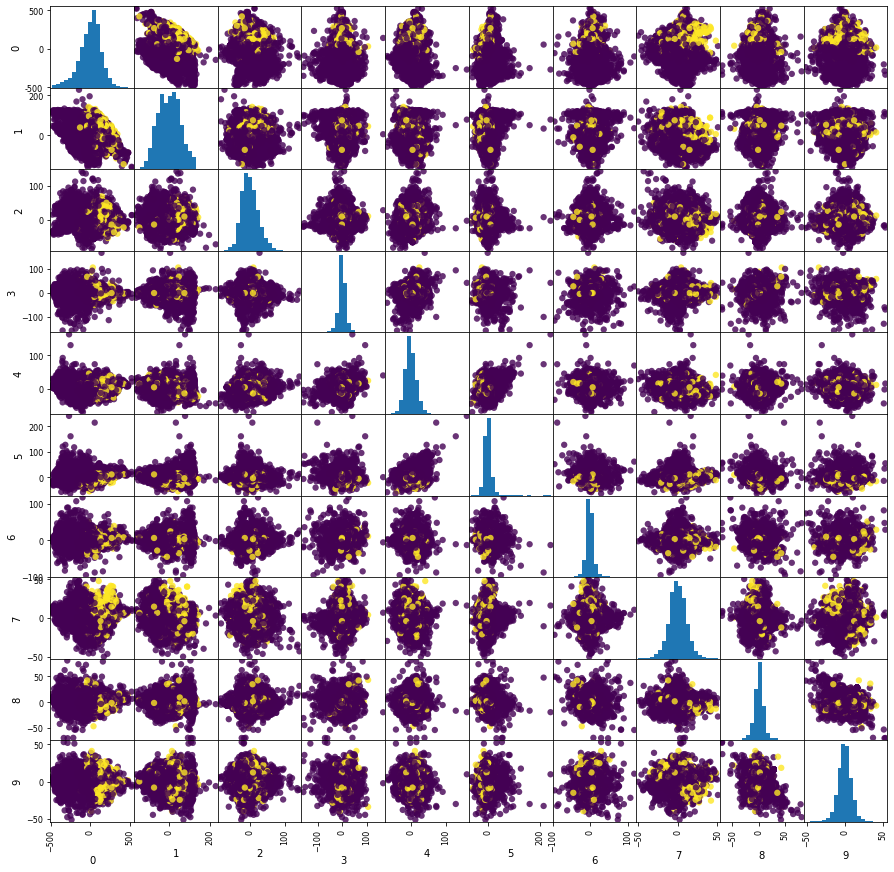

In [17]:
grr = pd.plotting.scatter_matrix(pd.DataFrame(X_transformed[:,:10]), c=y, figsize=(15, 15), marker='o',
hist_kwds={'bins': 20}, s=40, alpha=.8, cmap='viridis')

#### Nonlinear Dimensionality Reduction

PCA is a linear dimensionality reductions technique. Sometimes a linear transformation is not good enought to separate the data well. Then one can resort to nonlinear dimensionality reductions techniques, which find an embedding of the data in a lower domensional space, which preserves some properties of the geometry of the data. [TSNE](https://lvdmaaten.github.io/tsne/) is one such technique and it can be used very similarly to PCA.



In [18]:
%%time
# This function takes long to run, we will apply it to the first 10000 observations
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_transformed[:10000,:])
X_embedded.shape

CPU times: user 2min 2s, sys: 849 ms, total: 2min 2s
Wall time: 2min 2s


(10000, 2)

Text(0.5, 1.0, 'Projection of the data on 2 components')

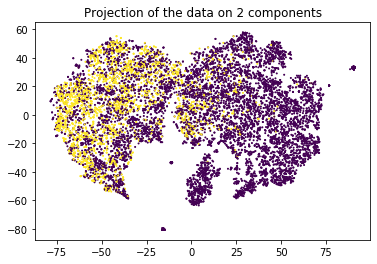

In [19]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],[],c=y[:10000])
plt.title("Projection of the data on 2 components")

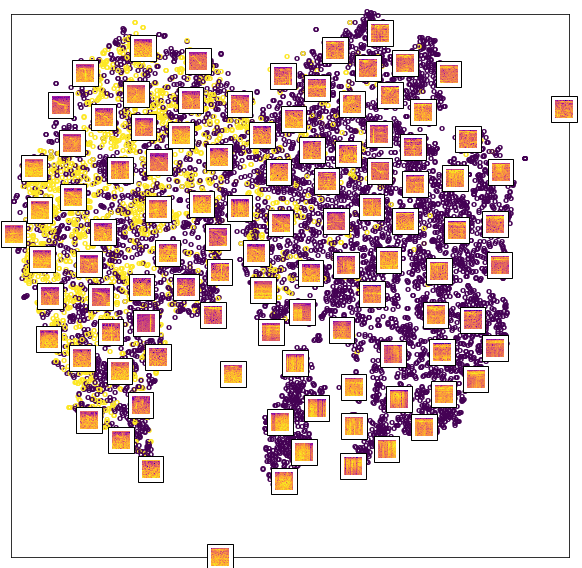

In [20]:
plot_embedding(np.array(X[:10000,:]), X_embedded)

More interactive ways to visualize large-dimensional data:

https://projector.tensorflow.org/

Blog on how it is done:

https://ai.googleblog.com/2018/06/realtime-tsne-visualizations-with.html


### References:
* https://github.com/jaimeps/whale-sound-classification

* https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf